### Notebook for the hands on session 5 (Self-consistent phonon calculation of cubic SrTiO3)

0. **Change directory**

    ```bash
    > cd ../../5_self_consistent_phonon_STO/work
    ```


1. **Compute harmonic IFCs and harmonic phonons**

    - Fit harmonic force constants
    
    ```sh
    > cp ../ref/ALM1.in .
    > alm ALM1.in > ALM1.log
    > grep "Fitting error" ALM1.log
      Fitting error (%) : 1.53358
    ```
    <br>
    - Compute band structure (harmonic)

    ```sh
    > cp ../ref/phband.in
    > anphon phband.in > phband.log
    ```

In [3]:
import numpy as np
import optparse
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
try:
    mpl.use("Qt5")
except:
    pass
import matplotlib.pyplot as plt

# parser options
usage = "usage: %prog [options] file1.bands file2.bands ... "
parser = optparse.OptionParser(usage=usage)

parser.add_option("--nokey", action="store_false", dest="print_key", default=True,
                  help="don't print the key in the figure")
parser.add_option("-u", "--unit", action="store", type="string", dest="unitname", default="kayser",
                  help="print the band dispersion in units of UNIT. Available options are kayser, meV, and THz", metavar="UNIT")
parser.add_option("--emin", action="store", type="float", dest="emin",
                  help="minimum value of the energy axis")
parser.add_option("--emax", action="store", type="float", dest="emax",
                  help="maximum value of the energy axis")
parser.add_option("--normalize", action="store_true", dest="normalize_xaxis", default=False,
                  help="normalize the x axis to unity.")


# font styles
mpl.rc('font', **{'family': 'Times New Roman', 'sans-serif': ['Helvetica']})
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=16)
mpl.rc('axes', labelsize=16)
mpl.rc('lines', linewidth=1.5)
mpl.rc('legend', fontsize='small')
# line colors and styles
color = ['b', 'g', 'r', 'm', 'k', 'c', 'y', 'r']
lsty = ['-', '-', '-', '-', '--', '--', '--', '--']


def get_kpath_and_kval(file_in):

    ftmp = open(file_in, 'r')
    kpath = ftmp.readline().rstrip('\n').split()
    kval = ftmp.readline().rstrip('\n').split()
    ftmp.close()

    if kpath[0] == '#' and kval[0] == '#':
        kval_float = [float(val) for val in kval[1:]]
        kpath_list = []
        for i in range(len(kpath[1:])):
            if kpath[i + 1] == 'G':
                kpath_list.append('$\Gamma$')
            else:
                kpath_list.append("$\mathrm{%s}$" % kpath[i + 1])

        return kpath_list, kval_float
    else:
        return [], []


def change_scale(array, str_scale):

    str_tmp = str_scale.lower()

    if str_tmp == 'kayser':
        print("Band structure will be shown in units of cm^{-1}")
        return array

    elif str_tmp == 'mev':
        print("Band structure will be shown in units of meV")
        kayser_to_mev = 0.0299792458 * 1.0e+12 * \
            6.62606896e-34 / 1.602176565e-19 * 1000

        for i in range(len(array)):
            for j in range(len(array[i])):
                for k in range(1, len(array[i][j])):
                    array[i][j][k] *= kayser_to_mev

        return array

    elif str_tmp == 'thz':
        print("Band structure will be shown in units of THz")
        kayser_to_thz = 0.0299792458

        for i in range(len(array)):
            for j in range(len(array[i])):
                for k in range(1, len(array[i][j])):
                    array[i][j][k] *= kayser_to_thz

        return array

    else:
        print("Unrecognizable option for --unit %s" % str_scale)
        print("Band structure will be shown in units of cm^{-1}")
        return array


def normalize_to_unity(array, array_axis):

    for i in range(len(array)):
        max_val = array[i][-1][0]

        factor_normalize = 1.0 / max_val

        for j in range(len(array[i])):
            array[i][j][0] *= factor_normalize

    max_val = array_axis[-1]
    factor_normalize = 1.0 / max_val

    for i in range(len(array_axis)):
        array_axis[i] *= factor_normalize

    return array, array_axis


def get_xy_minmax(array):

    xmin, xmax, ymin, ymax = [0, 0, 0, 0]

    for i in range(len(array)):
        xtmp = array[i][-1][0]
        xmax = max(xmax, xtmp)

    for i in range(len(array)):
        for j in range(len(array[i])):
            for k in range(1, len(array[i][j])):
                ytmp = array[i][j][k]
                ymin = min(ymin, ytmp)
                ymax = max(ymax, ytmp)

    return xmin, xmax, ymin, ymax


def gridspec_setup(data_merged, xtickslabels, xticksvars):

    xmaxs = []
    xmins = []

    xticks_grids = []
    xticklabels_grids = []
    xticklabels_tmp = []
    xticks_tmp = []

    for i in range(len(xtickslabels)):

        if i == 0:
            xmins.append(xticksvars[0])
        else:
            if xticksvars[i] == xticksvars[i-1]:
                xmaxs.append(xticksvars[i - 1])
                xmins.append(xticksvars[i])

                xticks_grids.append(xticks_tmp)
                xticklabels_grids.append(xticklabels_tmp)
                xticklabels_tmp = []
                xticks_tmp = []

        xticklabels_tmp.append(xtickslabels[i])
        xticks_tmp.append(xticksvars[i])

    xticks_grids.append(xticks_tmp)
    xticklabels_grids.append(xticklabels_tmp)
    xmaxs.append(xticksvars[-1])

    naxes = len(xticks_grids)
    nfiles = len(data_merged)

    data_all_axes = []

    for i in range(naxes):
        data_ax = []

        xmin_ax = xmins[i]
        xmax_ax = xmaxs[i]

        for j in range(nfiles):

            kval = np.array(data_merged[j][0:, 0])
            ix_xmin_arr = np.where(kval <= xmin_ax)
            ix_xmax_arr = np.where(kval >= xmax_ax)

            if len(ix_xmin_arr[0]) > 0:
                ix_xmin = int(ix_xmin_arr[0][-1])
            else:
                ix_xmin = 0

            if len(ix_xmax_arr[0]) > 0:
                ix_xmax = int(ix_xmax_arr[0][0])
            else:
                ix_xmax = -2

            data_ax.append(data_merged[j][ix_xmin:(ix_xmax+1), :])

        data_all_axes.append(data_ax)

    return naxes, xticks_grids, xticklabels_grids, xmins, xmaxs, data_all_axes


def preprocess_data(files, unitname, normalize_xaxis):

    xtickslabels, xticksvars = get_kpath_and_kval(files[0])

    data_merged = []

    for file in files:
        data_tmp = np.loadtxt(file, dtype=float)
        data_merged.append(data_tmp)

    data_merged = change_scale(data_merged, unitname)

    if normalize_xaxis:
        data_merged, xticksvars = normalize_to_unity(data_merged, xticksvars)

    xmin, xmax, ymin, ymax = get_xy_minmax(data_merged)

    factor = 1.05
    ymin *= factor
    ymax *= factor

    naxes, xticks_grids, xticklabels_grids, xmins, xmaxs, data_merged_grids \
        = gridspec_setup(data_merged, xtickslabels, xticksvars)

    return naxes, xticks_grids, xticklabels_grids, \
        xmins, xmaxs, ymin, ymax, data_merged_grids


def run_plot(nax, xticks_ax, xticklabels_ax, xmin_ax, xmax_ax, ymin, ymax, data_merged_ax, unitname):

    fig = plt.figure()

    width_ratios = []
    for xmin, xmax in zip(xmin_ax, xmax_ax):
        width_ratios.append(xmax - xmin)

    gs = GridSpec(nrows=1, ncols=nax, width_ratios=width_ratios)
    gs.update(wspace=0.1)

    for iax in range(nax):
        ax = plt.subplot(gs[iax])

        for i in range(len(data_merged_ax[iax])):

            if len(data_merged_ax[iax][i]) > 0:
                ax.plot(data_merged_ax[iax][i][0:, 0], data_merged_ax[iax][i][0:, 1],
                        linestyle=lsty[i], color=color[i], label=files[i])

                for j in range(2, len(data_merged_ax[iax][i][0][0:])):
                    ax.plot(data_merged_ax[iax][i][0:, 0], data_merged_ax[iax][i][0:, j],
                            linestyle=lsty[i], color=color[i])

        if iax == 0:
            if unitname.lower() == "mev":
                ax.set_ylabel("Frequency (meV)", labelpad=20)
            elif unitname.lower() == "thz":
                ax.set_ylabel("Frequency (THz)", labelpad=20)
            else:
                ax.set_ylabel("Frequency (cm${}^{-1}$)", labelpad=10)

        else:
            ax.set_yticklabels([])
            ax.set_yticks([])

        plt.axis([xmin_ax[iax], xmax_ax[iax], ymin, ymax])
        ax.set_xticks(xticks_ax[iax])
        ax.set_xticklabels(xticklabels_ax[iax])
        ax.xaxis.grid(True, linestyle='-')

        
        ax.legend(loc='best', prop={'size': 10})

    plt.show()

Band structure will be shown in units of meV


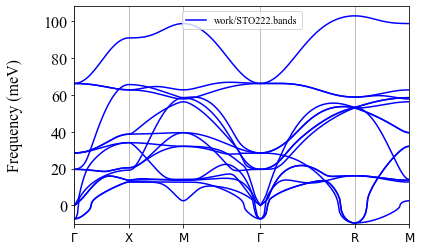

In [4]:
# Draw phonon dispersion curve
files = ['work/STO222.bands']
unitname = 'meV' # 'THz' or 'kayser'
normalize_xaxis = False

nax, xticks_ax, xticklabels_ax, xmin_ax, xmax_ax, ymin, ymax, data_merged_ax \
    = preprocess_data(files,unitname, normalize_xaxis)

run_plot(nax, xticks_ax, xticklabels_ax,
         xmin_ax, xmax_ax, ymin, ymax, data_merged_ax, unitname)

2. **LO-TO splitting (non-analytic correction)**

    - Extract dielectric tensor and Born effective charges from VASP output
    
    ```sh
    > python -m extract --VASP ../data/POSCAR --get born ../data/vasprun_epsilon.xml > BORN
    ```
    <br>
    
    - Compute phonon dispersion with non-analytic correction
    
    Please add `NONANALYTIC = 2` (Mixed-space approach) or `NONANALYTIC = 3` (Ewald method) as follows:
    
    ```
    &general
      PREFIX = STO222_NA2
      MODE = phonons
      NKD = 3; KD = Sr Ti O
      FCSXML = STO222.xml
      NONANALYTIC = 2
      BORNINFO = BORN
    / 
    ```
    <br>
    Then, run
    
    ```sh
    > anphon phband.in
    ```

Band structure will be shown in units of meV


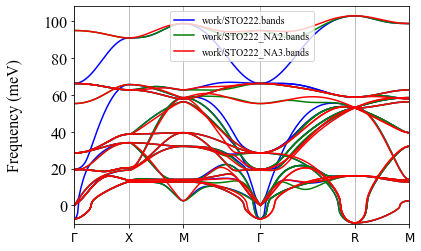

In [11]:
# Draw phonon dispersion curve
files = ['work/STO222.bands', 'work/STO222_NA2.bands', 'work/STO222_NA3.bands']
unitname = 'meV' # 'THz' or 'kayser'
normalize_xaxis = False

nax, xticks_ax, xticklabels_ax, xmin_ax, xmax_ax, ymin, ymax, data_merged_ax \
    = preprocess_data(files,unitname, normalize_xaxis)

run_plot(nax, xticks_ax, xticklabels_ax,
         xmin_ax, xmax_ax, ymin, ymax, data_merged_ax, unitname)

3. **Compute anharmonic force constants**

    <div class="alert alert-success">
    Since this part takes more than 10 minutes, you can just copy the provided ../ref/STO_anharm.xml file to the work directory. You can try this cell when you have enough time and resources.
    </div>

    ```sh
    > export OMP_NUM_THREADS=4
    > cp ../ref/CV.in .
    > alm CV.in > CV.log (takes more than 10 mins.)
    > cp ../ref/opt.in .
    > alm opt.in > opt.log
    ```
    

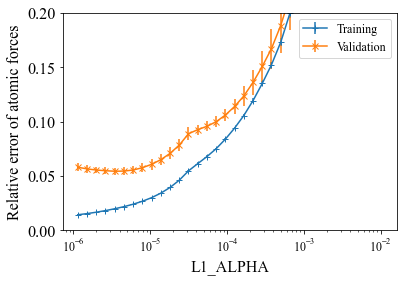

In [10]:
import matplotlib.pyplot as plt
import numpy as np

data = np.loadtxt('ref/STO_anharm.cvscore')

ax = plt.subplot(111)

ax.errorbar(x=data[:,0],y=data[:,1],yerr=data[:,2],marker='+', label='Training')
ax.errorbar(x=data[:,0],y=data[:,3],yerr=data[:,4],marker='x', label='Validation')
ax.set_xscale('log')
ax.set_xlabel('L1_ALPHA')
ax.set_ylabel('Relative error of atomic forces')

ax.set_ylim(0, 0.2)
#ax.set_xlim(1.0e-7, 1.0e-4)
ax.legend(loc='best', fontsize=12)

plt.savefig('cross-validation.pdf', bbox_inches='tight')
plt.show()

4. **Run self-consistent phonon calculation**

    - Create input file `scph.in`

        ```
        &general
         PREFIX = STO_scph2-2
         MODE = SCPH
         NKD = 3; KD = Sr Ti O
         FCSXML = STO_anharm.xml
         NONANALYTIC = 0; BORNINFO = BORN
         TMIN = 0; TMAX = 1000; DT = 50
        /

        &scph
         SELF_OFFDIAG = 0
         MAXITER = 500
         MIXALPHA = 0.2
         KMESH_INTERPOLATE = 2 2 2
         KMESH_SCPH = 2 2 2
        /

        &cell
         7.363
         1.0 0.0 0.0
         0.0 1.0 0.0
         0.0 0.0 1.0
        /

        &kpoint
         1
         G 0.0 0.0 0.0 X 0.5 0.0 0.0 51
         X 0.5 0.0 0.0 M 0.5 0.5 0.0 51
         M 0.5 0.5 0.0 G 0.0 0.0 0.0 51
         G 0.0 0.0 0.0 R 0.5 0.5 0.5 51
         R 0.5 0.5 0.5 M 0.5 0.5 0.0 51
        /
        ```
    <br>
    - Run SCPH calculation
    
    ```sh
    > export OMP_NUM_THREADS=4
    > anphon scph.in > scph.log
    > grep "conv" scph.log
    ```

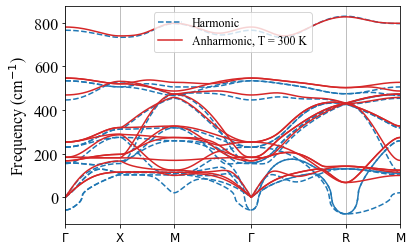

In [38]:
data = np.loadtxt('work/STO222_NA2.bands')
kpath, kval = get_kpath_and_kval('work/STO222_NA2.bands')

ax = plt.subplot(111)
ax.plot(data[:,0], data[:,1], linestyle='--', marker='None', ms=3, color='C0', label='Harmonic')
ax.plot(data[:,0], data[:,2:], linestyle='--', marker='None', ms=3, color='C0', label='_Harmonic')

scph = np.loadtxt('work/STO_scph2-2.scph_bands')
temperature = 300

scph = scph[np.where(scph[:,0]==temperature)]

ax.plot(scph[:,1], scph[:,2], linestyle='-', marker='None', ms=3, color='C3', label='Anharmonic, T = %d K' % temperature)
ax.plot(scph[:,1], scph[:,3:], linestyle='-', marker='None', ms=3, color='C3', label='_Harmonic')

ax.set_xlim(0, data[-1,0])
ax.set_xticks(kval)
ax.set_xticklabels(kpath)
ax.xaxis.grid(True, linestyle='-')
ax.set_ylabel(r"Frequency (cm$^{-1}$)")
ax.legend(loc='best', fontsize=12)

plt.show()

5. **Rerun SCPH with uniform k mesh**

    - Modify input file `scph.in`

        ```
        &general
         PREFIX = STO_scph2-2
         MODE = SCPH
         NKD = 3; KD = Sr Ti O
         FCSXML = STO_anharm.xml
         NONANALYTIC = 0; BORNINFO = BORN
         EMIN = -100; EMAX = 850; DELTA_E = 1.0
         TMIN = 0; TMAX = 1000; DT = 50
        /

        &scph
         SELF_OFFDIAG = 0
         MAXITER = 500
         MIXALPHA = 0.2
         KMESH_INTERPOLATE = 2 2 2
         KMESH_SCPH = 2 2 2
        /

        &cell
         7.363
         1.0 0.0 0.0
         0.0 1.0 0.0
         0.0 0.0 1.0
        /

        &kpoint
         2
         10 10 10
        /

        &analysis
         PRINTMSD = 1
        /
        ```
    <br>
    
    - Run ANPHON again
    
    ```sh
    > anphon scph.in
    ```

In [2]:
# Plot thermodynamic functions
import pandas as pd

fig = plt.figure(figsize=(16, 12))
gs = GridSpec(nrows=2, ncols=2)
gs.update(wspace=0.3)

thermo_scph = pd.read_csv('work/STO_scph2-2.scph_thermo', comment='#', 
                          header=None, 
                          delim_whitespace=True,
                          names=['Temperature (K)', '$C_v/k_B$', '$F_{vib}^{\mathrm{QHA}}$', '$\Delta F_{vib}$'])

thermo_scph['$F_{vib}^{\mathrm{QHA}}$'] *= 13.60569301
thermo_scph['$\Delta F_{vib}$'] *= 13.60569301
thermo_scph['$F_{vib}^{\mathrm{tot}}$'] = thermo_scph['$F_{vib}^{\mathrm{QHA}}$'] + thermo_scph['$\Delta F_{vib}$']


msd_scph = pd.read_csv('work/STO_scph2-2.scph_msd', comment = '#',
                       header=None, delim_whitespace=True,
                       names=['Temperature (K)', 'Sr:x,y,z', 'Ti:x,y,z', 'O_1:x', 'O_1:y,z'],
                       usecols=[0, 1, 4, 7, 8])

dos_scph = pd.read_csv('work/STO_scph2-2.scph_dos', comment = '#',
                       header=None, delim_whitespace=True,
                       names=['Frequency (cm$^{-1}$)'] + [('%d K' % t) for t in range(0, 1001, 50)])

ax = plt.subplot(gs[0])
thermo_scph.plot(x=0, y=1, ax=ax, legend=True, label='SCP')
ax.set_xlim(0)
ax.set_ylim(0)
ax.set_ylabel(thermo.columns[1])
ax.legend(loc='best', fontsize=12)

ax = plt.subplot(gs[1])
msd_scph.plot(x=0, y=1, ax=ax, legend=True, marker='.')
msd_scph.plot(x=0, y=2, ax=ax, legend=True, marker='.')
msd_scph.plot(x=0, y=3, ax=ax, legend=True, marker='.')
msd_scph.plot(x=0, y=4, ax=ax, legend=True, marker='.')
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend(loc='best', fontsize=12)
ax.set_ylabel('MSD ($\mathrm{\AA}^2$)')

ax = plt.subplot(gs[2])
dos_scph.plot(x=0, y='300 K', ax=ax, legend=True, marker='None', linestyle='-')
dos_scph.plot(x=0, y='1000 K', ax=ax, legend=True, marker='None', linestyle='-')
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend(loc='best', fontsize=12)
ax.set_yticks([])
ax.set_ylabel('DOS (arb units.)')

ax = plt.subplot(gs[3])
thermo_scph.plot(x=0, y=2, ax=ax, legend=True, marker='o')
thermo_scph.plot(x=0, y=3, ax=ax, legend=True, marker='o')
thermo_scph.plot(x=0, y=4, ax=ax, legend=True, marker='o')
ax.legend(loc='best', fontsize=12)
ax.set_xlim(0)
ax.set_ylabel('Free energy / f.u. (eV)')

plt.savefig('thermodynamic.pdf', bbox_inches='tight')    
plt.show()

NameError: name 'plt' is not defined

6. **Run SCPH calculation with classical option (optional)**

    By setting `CLASSICAL = 1`, all quantum statistical average is replaced with classical one.
    
    This option neglects the zero point motion of atoms, so we expect that the SCPH results will change in the low-temperature region.
    
    Please check if this is the case or not.
